# Action1基于高德地图的路径规划     

从指定地点start，到终点end的路径规划     最优路径定义：     1）距离最短     2）时间最短     输入：start,end     输出：路径规划，所需的距离、时间

1、完成代码（20points）     2、结果正确（20points）     能对地点的信息，使用高德地图API进行location     能使用最短路径算法进行路径规划，并能保存路径     能对算法API进行封装，并通过调用完成路径规划问题     

## 爬虫、数据收集整理

In [17]:
# 获得指定城市的地铁路线-北京
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [6]:
def get_page_content(request_url):
    # 得到页面的内容
    header={'user-agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131 Safari/537.36'}
    html = requests.get(request_url, headers=header, timeout=10)
    content = html.text
#     print(content)
    soup = BeautifulSoup(content, 'html.parser', from_encoding='utf-8')
    return soup
request_url = 'https://ditie.mapbar.com/beijing_line/'
soup = get_page_content(request_url)
subways = soup.find_all('div',class_='station')

df = pd.DataFrame(columns=['name','site'])

for subway in subways:
    # 得到线路名称
    route_name = subway.find('strong', class_='bolder').text
#     print('route_name=',route_name)
    # 找到该线路中每一站名称
    routes = subway.find('ul')
    routes = routes.find_all('a')
    for route in routes:
#         print(route.text)
        temp = {'name':route.text,'site':route_name}
        df = df.append(temp, ignore_index=True)
df

d:\学习\研究生\算法工程师\Bi\Bi_env\lib\site-packages\bs4\__init__.py:220: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


,name,site
0,四惠站,地铁八通线
1,四惠东站,地铁八通线
2,高碑店站,地铁八通线
3,传媒大学站,地铁八通线
4,双桥站,地铁八通线
...,...,...
346,永丰站,地铁16号线
347,永丰南站,地铁16号线
348,西北旺站,地铁16号线
349,马连洼站,地铁16号线


In [13]:
df['city'] = '北京'
df.to_excel('./subway.xlsx',index=False)

地铁站经纬度api
http://restapi.amap.com/v3/place/text?key=1396f4626d2408b9e2d42f89ba616b76&keywords=%E4%BA%94%E9%81%93%E5%8F%A3&types=&city=%E5%8C%97%E4%BA%AC&children=1&offset=1&page=1&extensions=all

地铁站距离api
http://restapi.amap.com/v3/distance?key=1396f4626d2408b9e2d42f89ba616b76&origins=116.337581,39.993138&destination=116.339941,39.976228&type=1



In [46]:
# 添加经度longitude，维度latitude
def get_location(keyword, city):
    header={'user-agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131 Safari/537.36'}
    request_url = 'http://restapi.amap.com/v3/place/text?key=1396f4626d2408b9e2d42f89ba616b76&keywords=' + \
    keyword + '&types=&city=' + \
    city +'&children=1&offset=1&page=1&extensions=all'
    data = requests.get(request_url, headers=header)
    data.encoding = 'utf-8'
    data = data.text
#     print(data)
    
    pattern = 'location":"(.*?),(.*?)"'
    result = re.findall(pattern, data)
#     print(result)
#     print(result[0][0], result[0][1])
    # 因为石门站有问题,可能高德地图没有石门站
    try:
        return result[0][0], result[0][1]
    except:
        return get_location(keyword.replace('站',''),city)
get_location('五道口站','北京')

('116.337581', '39.993138')

In [47]:
df = pd.read_excel('./subway.xlsx')
df['longitude'], df['latitude'] = None, None
for index,row in df.iterrows():
#     print(row['name'],row['city'])
    longitude, latitude = get_location(row['name'],row['city'])
    df.iloc[index]['longitude'] = longitude
    df.iloc[index]['latitude'] = latitude

In [48]:
df

,name,site,city,longitude,latitude
0,四惠站,地铁八通线,北京,116.498489,39.908279
1,四惠东站,地铁八通线,北京,116.514954,39.908051
2,高碑店站,地铁八通线,北京,115.858901,39.328727
3,传媒大学站,地铁八通线,北京,116.554931,39.909548
4,双桥站,地铁八通线,北京,116.569498,39.901066
...,...,...,...,...,...
346,永丰站,地铁16号线,北京,116.237766,40.071247
347,永丰南站,地铁16号线,北京,116.247876,40.064807
348,西北旺站,地铁16号线,北京,116.258460,40.048344
349,马连洼站,地铁16号线,北京,116.274073,40.032358


In [49]:
df.to_excel('./subway.xlsx',index=False)

## 路径规划

In [65]:
import pandas as pd
from collections import defaultdict
import re

In [52]:
# 数据加载
data = pd.read_excel('./subway.xlsx')
print(data)

      name    site city   longitude   latitude
0      四惠站   地铁八通线   北京  116.498489  39.908279
1     四惠东站   地铁八通线   北京  116.514954  39.908051
2     高碑店站   地铁八通线   北京  115.858901  39.328727
3    传媒大学站   地铁八通线   北京  116.554931  39.909548
4      双桥站   地铁八通线   北京  116.569498  39.901066
..     ...     ...  ...         ...        ...
346    永丰站  地铁16号线   北京  116.237766  40.071247
347   永丰南站  地铁16号线   北京  116.247876  40.064807
348   西北旺站  地铁16号线   北京  116.258460  40.048344
349   马连洼站  地铁16号线   北京  116.274073  40.032358
350    西苑站  地铁16号线   北京  116.291136  39.997817

[351 rows x 5 columns]


In [90]:
def compute_distance(longitude1, latitude1, longitude2, latitude2):
    header={'user-agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131 Safari/537.36'}
    request_url = 'http://restapi.amap.com/v3/distance?key=1396f4626d2408b9e2d42f89ba616b76&origins='+ \
    str(longitude1)+','+str(latitude1)+'&destination='+ \
    str(longitude2) +','+str(latitude2)+'&type=1'
    data = requests.get(request_url, headers=header)
    data.encoding = 'utf-8'
    data = data.text
#     print(data)
    pattern = 'distance":"(.*?)","duration":"(.*?)"' # 注意是.*?不是.?*
    result = re.findall(pattern, data)
#     print(result)
    return result[0][0]

In [83]:
#五道口的坐标(116.337581,39.993138)
#知春路的坐标(116.339941,39.976228)
compute_distance(116.337581,39.993138,116.339941,39.976228)

{"status":"1","info":"OK","infocode":"10000","results":[{"origin_id":"1","dest_id":"1","distance":"2646","duration":"660"}]}
2646 660


In [88]:
data

,name,site,city,longitude,latitude
0,四惠站,地铁八通线,北京,116.498489,39.908279
1,四惠东站,地铁八通线,北京,116.514954,39.908051
2,高碑店站,地铁八通线,北京,115.858901,39.328727
3,传媒大学站,地铁八通线,北京,116.554931,39.909548
4,双桥站,地铁八通线,北京,116.569498,39.901066
...,...,...,...,...,...
346,永丰站,地铁16号线,北京,116.237766,40.071247
347,永丰南站,地铁16号线,北京,116.247876,40.064807
348,西北旺站,地铁16号线,北京,116.258460,40.048344
349,马连洼站,地铁16号线,北京,116.274073,40.032358


In [91]:
# 保存途中两点之间的距离
graph = defaultdict(dict)
for i in range(data.shape[0]):
    site1 = data.iloc[i]['site']
    if i < data.shape[0]-1:
        site2 = data.iloc[i+1]['site']
        # 如果是同一条线路
        if site1 == site2:
            longitude1, latitude1 = data.iloc[i]['longitude'], data.iloc[i]['latitude']
            longitude2, latitude2 = data.iloc[i+1]['longitude'], data.iloc[i+1]['latitude']
            name1 = data.iloc[i]['name']
            name2 = data.iloc[i+1]['name']
            distance = compute_distance(longitude1, latitude1,longitude2, latitude2)
            graph[name1][name2] = distance
            graph[name2][name1] = distance
            print(name1, name2, distance)

四惠站 四惠东站 4143
四惠东站 高碑店站 102120
高碑店站 传媒大学站 108548
传媒大学站 双桥站 4827
双桥站 管庄站 3607
管庄站 八里桥站 3242
八里桥站 通州北苑站 3409
通州北苑站 果园站 1472
果园站 九棵树站 1510
九棵树站 梨园站 2323
梨园站 临河里站 2727
临河里站 土桥站 1674
西二旗站 生命科学园站 6812
生命科学园站 朱辛庄站 3479
朱辛庄站 巩华城站 6679
巩华城站 沙河站 6498
沙河站 沙河高教园站 3845
沙河高教园站 南邵站 6825
南邵站 北邵洼站 1981
北邵洼站 昌平东关站 2741
昌平东关站 昌平站 9602
昌平站 十三陵景区站 9552
十三陵景区站 昌平西山口站 2093
苏庄站 良乡南关站 2180
良乡南关站 良乡大学城西站 2266
良乡大学城西站 良乡大学城站 2707
良乡大学城站 良乡大学城北站 1514
良乡大学城北站 广阳城站 2768
广阳城站 篱笆房站 1243
篱笆房站 长阳站 2237
长阳站 稻田站 4280
稻田站 大葆台站 15844
大葆台站 郭公庄站 1951
宋家庄站 肖村站 3417
肖村站 小红门站 3757
小红门站 旧宫站 4522
旧宫站 亦庄桥站 3397
亦庄桥站 亦庄文化园站 2001
亦庄文化园站 万源街站 2362
万源街站 荣京东街站 1537
荣京东街站 荣昌东街站 1465
荣昌东街站 同济南路站 2340
同济南路站 经海路站 2331
经海路站 次渠南站 3275
次渠南站 次渠站 2001
东直门站 三元桥站 3133
三元桥站 三号航站楼站 21939
三号航站楼站 二号航站楼站 6395
二号航站楼站 三元桥站 19870
三元桥站 东直门站 3312
苹果园站 古城站 4650
古城站 八角游乐园站 3191
八角游乐园站 八宝山站 2190
八宝山站 玉泉路站 3591
玉泉路站 五棵松站 1734
五棵松站 万寿路站 2346
万寿路站 公主坟站 2217
公主坟站 军事博物馆站 2380
军事博物馆站 木樨地站 4988
木樨地站 南礼士路站 2051
南礼士路站 复兴门站 1819
复兴门站 西单站 5512
西单站 天安门西站 3765
天安门西站 天安门东站

In [96]:
list(graph.items())[:10]

[('四惠站', {'四惠东站': '4143', '大望路站': '4415'}),
 ('四惠东站', {'四惠站': '4143', '高碑店站': '102120'}),
 ('高碑店站', {'四惠东站': '102120', '传媒大学站': '108548'}),
 ('传媒大学站', {'高碑店站': '108548', '双桥站': '4827'}),
 ('双桥站', {'传媒大学站': '4827', '管庄站': '3607'}),
 ('管庄站', {'双桥站': '3607', '八里桥站': '3242'}),
 ('八里桥站', {'管庄站': '3242', '通州北苑站': '3409'}),
 ('通州北苑站', {'八里桥站': '3409', '果园站': '1472'}),
 ('果园站', {'通州北苑站': '1472', '九棵树站': '1510'}),
 ('九棵树站', {'果园站': '1510', '梨园站': '2323'})]

In [98]:
# import pickle
# output = open('graph','wb')
# pickle.dump(graph, output) 

In [99]:
import pickle
file = open('graph','rb')
graph = pickle.load(file)
print(graph)

defaultdict(<class 'dict'>, {'四惠站': {'四惠东站': '4143', '大望路站': '4415'}, '四惠东站': {'四惠站': '4143', '高碑店站': '102120'}, '高碑店站': {'四惠东站': '102120', '传媒大学站': '108548'}, '传媒大学站': {'高碑店站': '108548', '双桥站': '4827'}, '双桥站': {'传媒大学站': '4827', '管庄站': '3607'}, '管庄站': {'双桥站': '3607', '八里桥站': '3242'}, '八里桥站': {'管庄站': '3242', '通州北苑站': '3409'}, '通州北苑站': {'八里桥站': '3409', '果园站': '1472'}, '果园站': {'通州北苑站': '1472', '九棵树站': '1510'}, '九棵树站': {'果园站': '1510', '梨园站': '2323'}, '梨园站': {'九棵树站': '2323', '临河里站': '2727'}, '临河里站': {'梨园站': '2727', '土桥站': '1674'}, '土桥站': {'临河里站': '1674'}, '西二旗站': {'生命科学园站': '6812', '上地站': '2862', '龙泽站': '6892'}, '生命科学园站': {'西二旗站': '6812', '朱辛庄站': '3479'}, '朱辛庄站': {'生命科学园站': '3479', '巩华城站': '6679', '育知路站': '2964'}, '巩华城站': {'朱辛庄站': '6679', '沙河站': '6498'}, '沙河站': {'巩华城站': '6498', '沙河高教园站': '3845'}, '沙河高教园站': {'沙河站': '3845', '南邵站': '6825'}, '南邵站': {'沙河高教园站': '6825', '北邵洼站': '1981'}, '北邵洼站': {'南邵站': '1981', '昌平东关站': '2741'}, '昌平东关站': {'北邵洼站': '2741', '昌平站': '9602'}, '昌平站': {'昌平东关站': '9602', '十三

In [151]:
# 找到最小开销节点
def find_lowest_cost_node(costs):
    # 初始化数据
    lowest_cost = float('inf') # 打擂法，初始最小值为inf
    lowest_cost_node = None
    # 遍历所有节点
    for node in costs:
        # 如果该节点没有被处理
        if not node in processed:
            # 如果当前节点的开销比已经存在的开销小，那么就更新该节点为开销最小的节点
            if costs[node] < lowest_cost:
                lowest_cost = costs[node]
                lowest_cost_node = node
    return lowest_cost_node
# 找到最短路径
def find_shortest_path():
    node = end
    shortest_path = [end]
    # 最终的根节点为start
    while parents[node] != start:
        # 往前移动一步
        node = parents[node]
        # 添加到路径中
        shortest_path.append(node)
    shortest_path.append(start)    
    return shortest_path

# 计算图中从start到end的最短路径
def dijkstra():
    # 查询到目前开销最小的节点,从U中
    node = find_lowest_cost_node(costs)
#     print(node)
    print('距离{}最近的地铁站：{}'.format(start,node))
    # 使用找到的开销最小的节点，计算它的邻居，是否可以通过它进行更新
    # 如果所有的节点，都在processed，就结束
    while node is not None:
        # 获取节点的cost
        cost = costs[node] # cost 是从node到start距离
        # 获取节点的邻居
        neighbors = graph[node]
        # 遍历所有邻居，看是否通过它进行更新
        for neighbor in neighbors.keys():
            # 计算邻居到当前节点 + 当前节点开销
            new_cost = cost + float(neighbors[neighbor])
            if neighbor not in costs or new_cost < costs[neighbor]:
                costs[neighbor] = new_cost
                # 经过node到达neighbor节点，cost更少
                parents[neighbor] = node
        # 将当前节点，标记为已处理
        processed.append(node)
        # 下一步，继续找u中最短距离的节点
        # costs是dijstra中的U， precessed=S  --> Step1，S={D(0)}, U={A(∞),B(∞),C(3),E(4),F(∞),G(∞)}
        node = find_lowest_cost_node(costs)
#         print('当前cost最小节点：',node)
        
    # 循环完以后，说明所有节点已经处理完
    shortest_path = find_shortest_path()
    shortest_path.reverse()
    print('从{}到{}的最短路径：{}'.format(start, end, shortest_path))

In [159]:
start = '首经贸站'
end = '五道口站'
# 创建节点的开销表，cost是指从start到该节点的距离
costs = {}
# 存储父节点的Hash表，用于记录路径
parents = {}
parents[end] = None

# 获取节点相邻的节点
for node in graph[start].keys():
    costs[node] = float(graph[start][node])
    parents[node] = start


# 终点到起始点 设置为无穷大
costs[end] = float('inf')
    
# 记录处理过的节点list
processed = []

In [160]:
costs

{'纪家庙站': 2288.0, '丰台站': 2131.0, '五道口站': inf}

In [153]:
dijkstra()

距离首经贸站最近的地铁站：丰台站
从首经贸站到五道口站的最短路径：['首经贸站', '丰台站', '泥洼站', '西局站', '六里桥站', '六里桥东站', '北京西站', '军事博物馆站', '白堆子站', '白石桥南站', '国家图书馆站', '魏公村站', '人民大学站', '海淀黄庄站', '知春里站', '知春路站', '五道口站']


In [162]:
# 没考虑地铁的曲线距离和车速，所以直接以直线距离判断从六里桥换乘9号线到六里桥东最近
graph['六里桥站']

{'七里庄站': '2067', '六里桥东站': '1311', '西局站': '2752', '莲花桥站': '2867'}

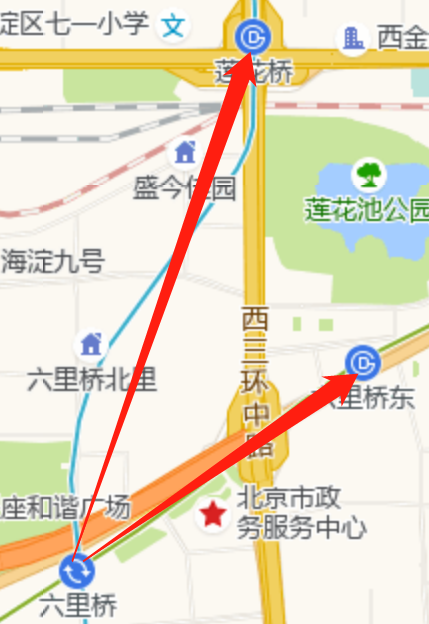